In [201]:
#!pip install numpy pandas matplotlib seaborn
#!pip install sklearn

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Introduction
The dataset I chose for this project is a collection of user reviews of the game Starfield from the distribution platform Steam. I selected Starfield because it is a recent, high-profile game with a good balance of positive and negative reviews. Going into this project, I wanted to create a way of automatically classifying Starfield reviews as positive or negative and find out what type of language is most common in positive and negative reviews.

## Collecting Data

#### *Data Scraping Functions*
Based on <a href="https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92">this guide by Andrew Muller</a>,
I scraped 5,000 of the most recent Steam reviews for the game Starfield. This code can scrape any number of reviews from any game on Steam by inputting the AppID into the get_n_reviews(appid, n) function. This function will return a JSON file of all n reviews and their fields. The fields of each review can be found on the <a href="https://partner.steamgames.com/doc/store/getreviews">Steamworks Documentation</a>.

In [203]:
# Reference - https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92

# The following gathers the most recent reviews that follow certain criteria
import json
import requests

def get_reviews(appid, params={'json':1}):
        # Unique page for every Steam app that displays review data in .json format
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

# Gets specified number of the most recent reviews
def get_n_reviews(appid, n):
    reviews = []
    cursor = '*' # Can gather more than 20 reviews at once
    params = { # More info - https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'recent', # sorted by recency
            'language' : 'english',
            'day_range' : 365, # Posted between now and specified day_range
            'review_type' : 'all', # Both positive and negative reviews
            'purchase_type' : 'steam' # Reviews by users who purchased the game and didn't receive it for free
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

#### *Calling Scraping Functions, Saving the Data*

In [204]:
datapath = "./data"

dataset_size = 5000 # number of reviews
dataset = get_n_reviews(1716740, dataset_size) # the number is the game's Steam AppID

with open(datapath+"/reviews.json", 'w') as f:
    json.dump(dataset, f)

df_raw = pd.read_json(datapath+"/reviews.json")
df = pd.concat([df_raw.drop(['author'],axis=1),df_raw['author'].apply(pd.Series)],axis=1)
df.to_csv(datapath+"/reviews.csv")

In [205]:
df.head()

recommendationid language  \
0         159414385  english   
1         159413338  english   
2         159411927  english   
3         159408614  english   
4         159401842  english   

                                              review   timestamp_created  \
0  I don't get all the blaming about this game.\n... 2024-02-27 20:15:24   
1  Took time off work, was hyped beyond belief. P... 2024-02-27 19:55:17   
2                                                fun 2024-02-27 19:29:29   
3  First off to all of you bethesda fan folks out... 2024-02-27 18:32:29   
4  After 170 odd hours of play for a game that wa... 2024-02-27 16:31:13   

    timestamp_updated  voted_up  votes_up  votes_funny  weighted_vote_score  \
0 2024-02-27 20:15:24      True         0            0             0.000000   
1 2024-02-27 19:55:17     False         1            0             0.523810   
2 2024-02-27 19:29:29      True         0            0             0.000000   
3 2024-02-27 18:32:29      True         0            0             0.486947   
4 2024-02-27 16:31:13     False         1            0             0.000000   

   comment_count  ...  written_during_early_access  hidden_in_steam_china  \
0              0  ...                        False                   True   
1              0  ...                        False                   True   
2              0  ...                        False                   True   
3              0  ...                        False                   True   
4              0  ...                        False                   True   

   steam_china_location            steamid num_games_owned num_reviews  \
0                        76561198028386919               0          20   
1                        76561198072316501               0           1   
2                        76561198814019283               0           1   
3                        76561198082160794               0           6   
4                        76561198007799245               0           5   

   playtime_forever  playtime_last_two_weeks  playtime_at_review  last_played  
0              2511                     1196                2511   1709063976  
1              8558                        0                8558   1707086335  
2              9679                     3266                9619   1709069158  
3               762                      252                 762   1708957253  
4             10472                        0               10472   1696787918  

[5 rows x 22 columns]

## Cleaning Data
Only the content of the review and the category ("voted_up") of the review are important for this project. All other columns in the dataset are dropped.

In [274]:
df_clean = df.drop(df.columns.difference(['review','voted_up']), axis=1)

In [207]:
df_clean.head()

review  voted_up
0  I don't get all the blaming about this game.\n...      True
1  Took time off work, was hyped beyond belief. P...     False
2                                                fun      True
3  First off to all of you bethesda fan folks out...      True
4  After 170 odd hours of play for a game that wa...     False

## Data Visualization
Below are the most used words in positive and negative reviews respectively. This can be compared to the logistical regression model's feature coefficients later.

#### *Positive*

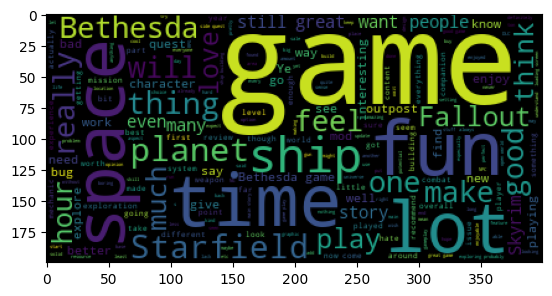

In [271]:
reviews = ''

for i in range(len(df_clean)):
    if df_clean["voted_up"][i] == True:
        reviews += df_clean['review'][i]

wc = WordCloud().generate(reviews)
plt.imshow(wc)

#### *Negative*

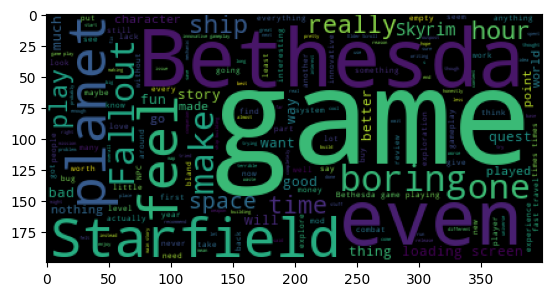

In [272]:
reviews = ''

for i in range(len(df_clean)):
    if df_clean["voted_up"][i] == False:
        reviews += df_clean['review'][i]

wc = WordCloud().generate(reviews)
plt.imshow(wc)

## Modeling

This section is based on <a href="https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/">this article by Usman Malik</a> and <a href="https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/">this article by Morgan Fitzgerald</a>.

In [320]:
# https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/
# https://medium.com/@morgan.fitzgerald/visualizing-feature-importance-in-a-simple-text-classification-model-b0495197eac

I elected to use logistical regression to classify the reviews. Logistical regression uses a sigmoid function to create predictions on a scale of 0 to 1 based on a set of independent variables using the sigmoid function (<a href="https://www.ibm.com/topics/logistic-regression">source</a>). Since the words of a review can be converted into independent variables and assigned weights based on frequency, this allows the logistical regression model to make predictions using text instead of numerical data.

#### *Splitting the Data*
"X" represents each review while "y" represents each review's corresponding category (True or False). These are split into two groups: a training group and a testing group. The model needs to be tested on different data than it was trained on to make sure it is generalizing and not memorizing. If the model is tested on the same data is is trained on, it will be disproportionally effective at categorizing the reviews.

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
X = df_clean['review']
y = df_clean['voted_up']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### *Vectorizing the Reviews*
Because the reviews are comprised of words and not numbers, the model cannot perform calculations with them. To allow the model to understand how to process words, all the reviews are converted into a 2D array. Each sub-array represents an individual review, and each index of the sub-array represents each word in the global vocabulary. Each index stores a number representing the number of times the associated word is used in an individual array.
<br><br>
For example, given these reviews:<br>
Review 1: "this game is great"<br>
Review 2: "i hate this game"<br>
Review 3: "i like some things about this game but i dislike other things about this game"<br>
<br>
we can collect each time an individual word is used:<br>
{this, game, is, great, i, hate, like, some, things, about, but, dislike}<br>
<br>
and count the number of time they are used in each review:<br>
Review 1: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
Review 2: [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]<br>
Review 3: [2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 1, 1]<br>
<br>
However, some words are repeated very often but do not affect the sentiment of the review. Words such as "the" and "and" are good examples of this. These words can muddy the importance of each word on the sentiment of the review. Instead of creating the feature vectors based on frequency, I used TF-TDF vectorization, which uses an algorithm to normalize the importance of frequency on the sentiment of the document. More about TF-IDF can be found <a href="https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/">here</a>.

In [306]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [330]:
vect_tfidf = TfidfVectorizer(max_features=3000).fit(X_train)
X_train_vectorized = vect_tfidf.fit_transform(X_train).toarray()
vect_df = pd.DataFrame(X_train_vectorized)
vect_df

0         1         2     3     4     5     6     7     8     9     ...  \
0      0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1      0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2      0.0  0.060085  0.073015   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3      0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4      0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...    ...       ...       ...   ...   ...   ...   ...   ...   ...   ...  ...   
3995   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3996   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3997   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3998   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3999   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

      2990      2991      2992      2993  2994  2995  2996  2997  2998  2999  
0      0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0  0.036393  0.108346  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...       ...       ...       ...   ...   ...   ...   ...   ...   ...  
3995   0.0  0.000000  0.103104  0.213080   0.0   0.0   0.0   0.0   0.0   0.0  
3996   0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
3997   0.0  0.000000  0.067580  0.139664   0.0   0.0   0.0   0.0   0.0   0.0  
3998   0.0  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
3999   0.0  0.000000  0.104137  0.143476   0.0   0.0   0.0   0.0   0.0   0.0  

[4000 rows x 3000 columns]

#### *Training the Model*
Now, the training split of the vectorized reviews and their labels are fed into the logistical regression model as training data.

In [308]:
from sklearn.linear_model import LogisticRegression

In [309]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

#### *Model Performance*
After training the model, I fed the testing split of the vectorized reviews into the model to be classified. I used F1 scoring to evaluate the performance of the model. An F1 score is calculated using the harmonic mean of precision and recall, and is calculated using the formula below (<a href="https://lifewithdata.com/2022/02/22/what-is-f1-score-in-machine-learning/">source</a>). I am using and F1 score to evaluate the model because it more accurately determines a model's performance when the dataset is imbalanced, and is often used to score logistical regression models. More about F1 scores and why to use them can be found <a href="https://www.statology.org/f1-score-vs-accuracy/">here</a>.
<br>
<img src="https://i0.wp.com/lifewithdata.com/wp-content/uploads/2022/02/f11.jpeg?w=1067&ssl=1">
<br>
The highest I could get the model to score was 81%, which is pretty low. After struggling to improve the model, I decided to investigate the feature coefficients. Feature coefficients are the weights assigned to each feature as calculated by the logistical regression model. Features with high coefficients are strongly associeted with positive reviews and features with low coefficients are strongly associated with negative reviews.

In [310]:
from sklearn import metrics

In [311]:
predictions = model.predict(vect_tfidf.transform(X_test))
print(metrics.f1_score(y_test, predictions))

0.8137931034482758


#### *Feature Coefficients*
I combined the model's vocabulary and the coefficients into a Data Frame so I could sort and visualize the features and their coefficients. Below are the words most associated with positive reviews and their coefficients, followed by the words most associated with negative reviews and their coefficients. I expected to see words such as "good" or "fun" with the highest coefficients while words such as "boring" or "bad" with the lowest coefficients. However, most of the words in the top and bottom 5 had no strong negative or positive connotations. In fact, some of the features with the highest coefficients, such as "mid" and "waste," have negative connotations.

In [319]:
coef_df = pd.DataFrame(list(zip(vect_tfidf.vocabulary_, model.coef_[0])), columns = ['word', 'coef'])

In [332]:
coef_df.sort_values(by='coef', ascending=False).head()

word      coef
1605      mid  3.878338
1184     card  3.876209
839     waste  2.635767
1939  hostile  2.542642
1105    means  2.432246

In [314]:
coef_df.sort_values(by='coef', ascending=True).head()

word      coef
313          by -4.941284
1385    mystery -3.342326
1800  marketing -2.717202
869         buy -2.612808
1459   suddenly -2.540974

Below are the words clouds for the most positive and most negative features by coefficients. Compared to the word clouds that I created based on frequency per calassification, the words clouds below seem arbitrary and unclear.

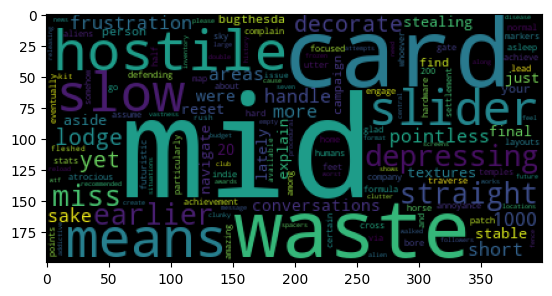

In [315]:
# Positive
coef_list = list(zip(vect_tfidf.vocabulary_, model.coef_[0]))
coef_dict = {i[0]: i[1] for i in coef_list}

wc = WordCloud().generate_from_frequencies(coef_dict)
plt.imshow(wc)

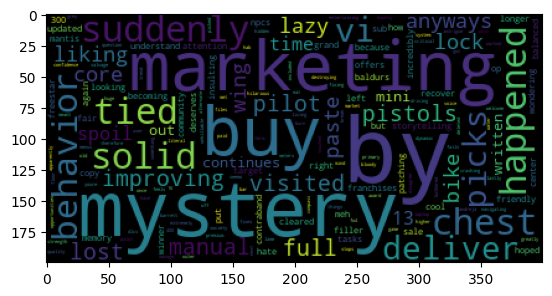

In [316]:
# Negative
coef_list = list(zip(vect_tfidf.vocabulary_, model.coef_[0]*-1))
coef_dict = {i[0]: i[1] for i in coef_list}

wc = WordCloud().generate_from_frequencies(coef_dict)
plt.imshow(wc)

## Conclusion
#### *Results*
By looking at the feature coefficients, I can tell that the logistical regression model had difficulties picking up on which words were most associated with positive and negative reviews. I think this could be one of the main reasons that the model performed poorly. However, I am not sure which part of the project is causing this issue. Because of the inaccuracy of the model and the confusing feature coefficients, I am not confident in the results of this project and therefore, am not able to determine my initial question: What words are most associated with positive and negative reviews?

#### *Impact*
This project has shown me that logistical regression models need to be refined by knowledgeable researchers in order to be used for reliable text classification. I believe that my lack of understanding and expertise in Natural Language Processing and logistical regression led me to make errors that I have not been able to correctly identify. I think it is important for those who intend to machine learning to analyze data to have a full understanding of their data and their processes so as to not misunderstand the results of their experiments. For example, if Steam were to use my experiment to better understand user reviews, they would get an inaccurate and incomplete picture of the ways in which users write about games.